<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импортируем-используемые-библиотеки" data-toc-modified-id="Импортируем-используемые-библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импортируем используемые библиотеки</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обработка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Подбор-по-параметрам" data-toc-modified-id="Подбор-по-параметрам-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Подбор по параметрам</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Заключение</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

**Признаки:**  
- RowNumber — индекс строки в данных  
- CustomerId — уникальный идентификатор клиента  
- Surname — фамилия  
- CreditScore — кредитный рейтинг  
- Geography — страна проживания  
- Gender — пол  
- Age — возраст  
- Tenure — сколько лет человек является клиентом банка  
- Balance — баланс на счёте  
- NumOfProducts — количество продуктов банка, используемых клиентом  
- HasCrCard — наличие кредитной карты  
- IsActiveMember — активность клиента  
- EstimatedSalary — предполагаемая зарплата  

**Целевой признак**  
- Exited — факт ухода клиента

## Импортируем используемые библиотеки

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from pylab import rcParams
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, roc_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [73]:
#Настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

#Зададим размеры фигуры для вывода графиков и гистограмм
rcParams['figure.figsize'] = [10, 5]
rcParams['lines.color'] = 'r'

#Настроим местоположение и размер шрифта для легенды графиков и гистограмм
rcParams['legend.loc'] = 'lower right'
rcParams['legend.fontsize'] = 14

In [74]:
#Вынесем постоянные параметры

MY_RANDOM_STATE = 19221981

## Изучение данных

In [75]:
#Загрузим данные и посмотрим первые 5 строк

df = pd.read_csv('C:/Users/User/Desktop/Churn/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [76]:
#Посмотрим из чего состоит датасет

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [77]:
df.shape

(10000, 14)

In [78]:
#Посмотрим статистики

df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


In [79]:
df.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


**После изучения данных можно сделать следующие выводы:**  
- датасет состоит из 10000 строк и 14 столбцов;    
- присутствуют как числовые, так и 3 категориальных признака Surname, Geography, Gender;  
- есть пропуски в столбце Tenure;  
- минимальный возраст клиентов 18 лет, максимальный 92 года, средний возраст 39 лет;  
- средний кредитный рейтинг 651 бал;  
- клиенты представлены тремя странами, больше всего французов;
- можем удалить столбцы RowNumber, CustomerId, Surname т.к. очевидно, что эти признаки не влияют на решение клиента раторгнуть договор.


## Обработка данных

In [80]:
#Удалим столбцы

df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.shape

(10000, 11)

In [81]:
#Посмотрим какой процент пропусков

df['Tenure'].isnull().sum()*100/len(df)

9.09

Доля пропущеных значений в столбце Tenure (сколько времени человек является клиентом банка) равно 10%.  
10% это приличная доля поэтому не будем удалять пропуски. 
Средним и медианным значением тоже заменять будет не совсем корректно, т.к. это могут быть клиенты, которые обслуживаются менее года.  
Думаю можно пропуски заменить на нули.

In [82]:
#Произведем замену

df['Tenure'] = df['Tenure'].fillna(0)

In [83]:
#Проверим

df['Tenure'].isnull().sum()

0

In [84]:
#Сделаем грубую проверку на дубликаты

df.duplicated().sum()

0

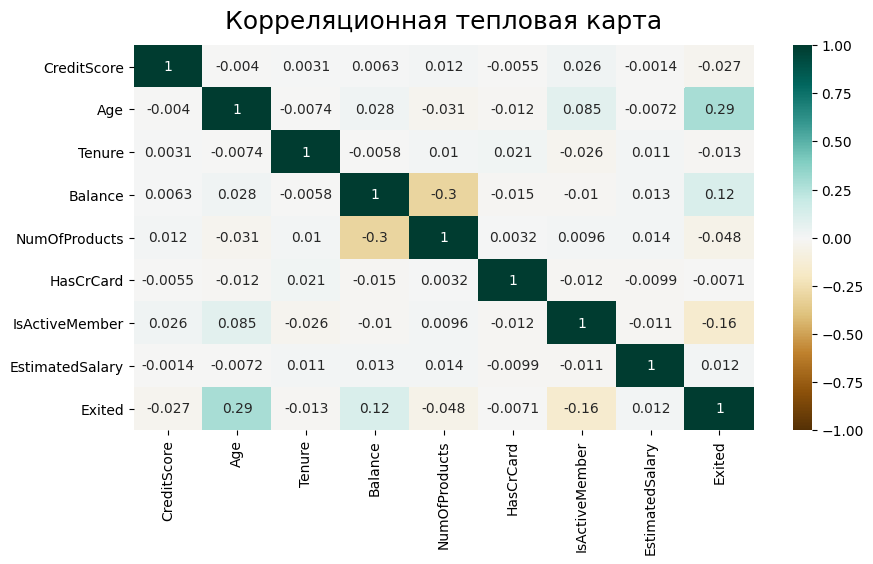

In [85]:
# Построим тепловую карту корреляций

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляционная тепловая карта', fontdict={'fontsize':18}, pad=12)
plt.show()

Сильных зависимостей признаков нет, это хорошо, т.к. нет мультиколлинеарности

In [86]:
#Проверим выборку на дисбаланс классов

df['Exited'].value_counts(normalize=True)

0   0.80
1   0.20
Name: Exited, dtype: float64

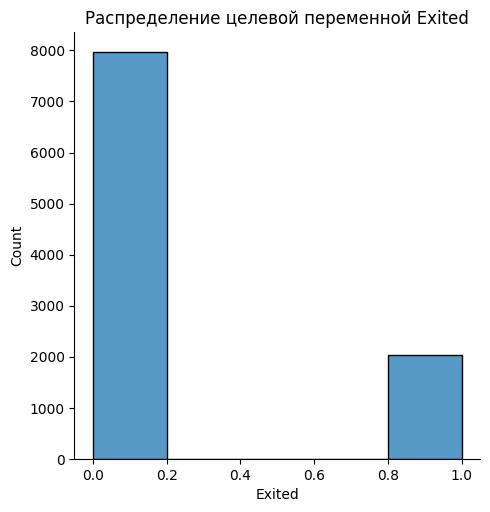

In [87]:
sns.displot(df['Exited'], bins=5)
plt.title('Распределение целевой переменной Exited');

Мы видим, что дисбаланс большой 80% отрицательных значений и только 20% положительных.

In [88]:
#Преобразуем категориальные признаки техникой One-Hot Encoding, 
# т.к. эта техника работает со всеми тремя моделями, которые мы будем использовать

df_ohe = pd.get_dummies(df, drop_first=True)
display(df_ohe.head())
display(df_ohe.shape)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.00,0.00,1,1,1,"101,348.88",1,0,0,0
1,608,41,1.00,"83,807.86",1,0,1,"112,542.58",0,0,1,0
2,502,42,8.00,"159,660.80",3,1,0,"113,931.57",1,0,0,0
3,699,39,1.00,0.00,2,0,0,"93,826.63",0,0,0,0
4,850,43,2.00,"125,510.82",1,1,1,"79,084.10",0,0,1,0


(10000, 12)

In [89]:
#Создадим переменные с признаками и целевым признаком

target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

In [90]:
#Разделим выборки на обучающую, валидационную и тестовую в соотношении 3.1.1
#Используем stratify, чтобы разбиение было сбалансировнно по классам

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state = MY_RANDOM_STATE, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
    target_valid, test_size=0.5, random_state = MY_RANDOM_STATE, stratify = target_valid)

In [91]:
print(f'{target_train.shape} {len(target_train)/len(df_ohe)}')
print(f'{target_valid.shape} {len(target_valid)/len(df_ohe)}')
print(f'{target_test.shape} {len(target_test)/len(df_ohe)}')

(6000,) 0.6
(2000,) 0.2
(2000,) 0.2


Разбили выборку, в рузультате получили:  
- обучающая выборка 60%  
- валидационная выборка 20%  
- тестовая выборка 20%

In [92]:
#Проверим как прошло разбиение по классам

print(f'Количество строк в train по классам: {np.bincount(target_train)}')
print(f'Количество строк в valid по классам: {np.bincount(target_valid)}')
print(f'Количество строк в test по классам:  {np.bincount(target_test)}')

Количество строк в train по классам: [4778 1222]
Количество строк в valid по классам: [1593  407]
Количество строк в test по классам:  [1592  408]


In [93]:
print(target_train.value_counts(normalize=True))
print(target_valid.value_counts(normalize=True))
print(target_test.value_counts(normalize=True))

0   0.80
1   0.20
Name: Exited, dtype: float64
0   0.80
1   0.20
Name: Exited, dtype: float64
0   0.80
1   0.20
Name: Exited, dtype: float64


In [94]:
#Масштабируем признаки, путем стандартизации, чтобы избежать большого разброса данных

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3204,-1.09,1.03,-0.50,0.06,2.56,0,1,1.37,1,0,1
4993,-1.02,0.47,0.46,0.24,-0.90,1,0,0.47,0,0,0
2076,0.02,0.09,0.46,-1.25,-0.90,0,0,1.48,0,0,1
782,-1.40,0.19,-0.83,-1.25,0.83,0,1,-0.41,0,0,1
27,-0.84,0.47,1.43,-1.25,0.83,0,0,-1.07,0,0,1


**В процессе обработки данных сделали следующее:**  
- удалили столбцы, которые не оказывают влияние на выполнение нашей задачи;  
- пропущенные значения в столбце Tenure заменили на нули;  
- проверили корреляцию признаков (большая корреляция между признаками отсутствует);  
- проверили выборку на дисбаланс классов, оказалось, что 80% у нас отрицательный класс (нули) и 20% положительный класс (единицы);  
- категориальные признаки в столбце Gender_Male и Geography преобразовали в количественные техникой OHE;  
- создали переменные features c признаками и target c целевым признаком Exited;  
- разбили нашу выборку на три в пропорции 60% тренировочная, 20% валидационная и 20% тестовая;
- использовали Stratify для равномерного распределения классов по выборкам;  
- при помощи StandardScaler привели признаки к одному масштабу.

## Исследование задачи

**Будем рассматривать модели без подбора параметров**

*Рассмотрим модель Decision Tree*

In [95]:
#Проверим метрики модели без дополнительных гиперпараметров

DT = DecisionTreeClassifier(random_state=MY_RANDOM_STATE).fit(features_train, target_train)
predict_DT = DT.predict(features_valid)
F1_DT = f1_score(target_valid, predict_DT)
print(f'F1: {F1_DT: .2f}')

F1:  0.53


In [96]:
#Построим матрицу ошибок

confusion_matrix(target_valid, predict_DT)

array([[1410,  183],
       [ 195,  212]], dtype=int64)

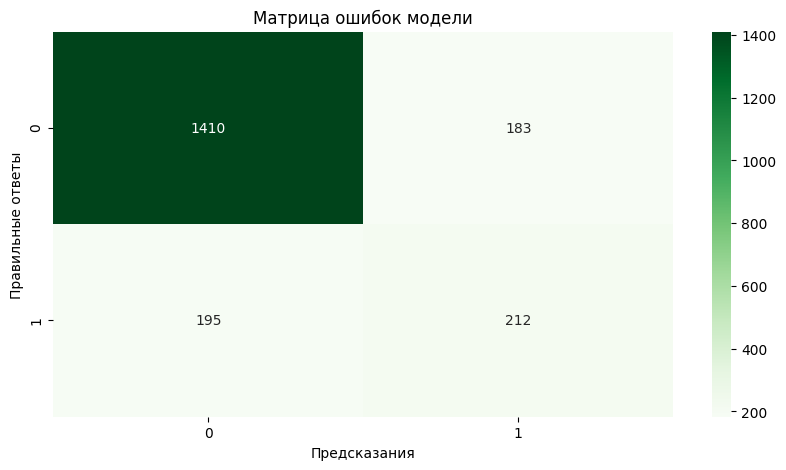

In [97]:
#plot_confusion_matrix(DT, features_valid, target_valid, cmap='Greens')
#plt.show()
sns.heatmap(confusion_matrix(target_valid, predict_DT),
            annot=True, cmap='Greens', fmt='g')
plt.title(f'Матрица ошибок модели')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()


Как видим метрика F1 не очень высокая, всего 0,53. Также видим, что распределение TP, FP и FN примерно одинаковое.

In [98]:
#найдем ROC_AUC

probabil_valid_DT = DT.predict_proba(features_valid)
probabil_one_valid_DT = probabil_valid_DT[:, 1]
AUC_ROC_DT = roc_auc_score(target_valid, probabil_one_valid_DT)
print(f'AUC_ROC модели DT: {AUC_ROC_DT: .2f}')

AUC_ROC модели DT:  0.70


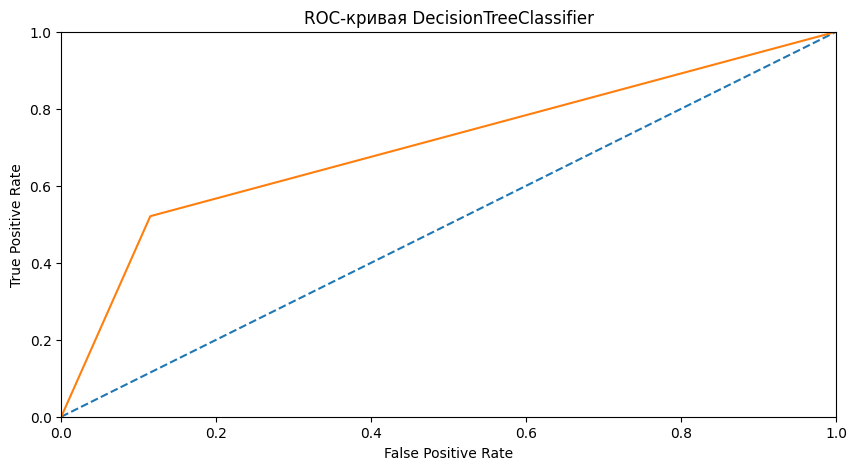

In [99]:
#Построим ROC кривую

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_DT) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot (fpr,tpr)
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая DecisionTreeClassifier')
plt.show()

Видим, что значение AUC_ROC не очень высокое.

*Рассмотрим модель RandomForest*

In [100]:
RF = RandomForestClassifier(random_state=MY_RANDOM_STATE).fit(features_train, target_train)
predict_RF = RF.predict(features_valid)
F1_RF = f1_score(target_valid, predict_RF)
print(f'F1: {F1_RF: .2f}')

F1:  0.57


In [101]:
#постоим матрицу ошибок

confusion_matrix(target_valid, predict_RF)

array([[1541,   52],
       [ 224,  183]], dtype=int64)

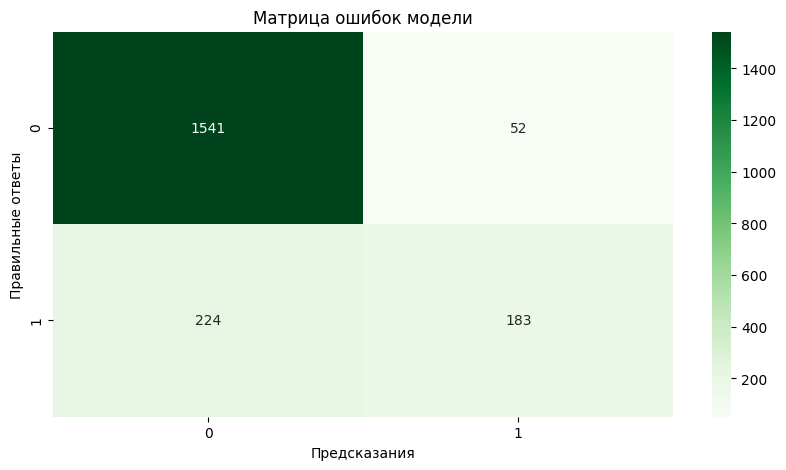

In [102]:
sns.heatmap(confusion_matrix(target_valid, predict_RF),
            annot=True, cmap='Greens', fmt='g')
plt.title(f'Матрица ошибок модели')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()


Тут значение F1 выше чем у предыдущей модели, но все равно не достаточно высокое. Как видим по матрице у этой моделе идеть смещение в пользу Precision. Т.к. значение FP уменьшилось, а FN увеличилось.

In [103]:
#найдем ROC_AUC

probabil_valid_RF = RF.predict_proba(features_valid)
probabil_one_valid_RF = probabil_valid_RF[:, 1]
AUC_ROC_RF = roc_auc_score(target_valid, probabil_one_valid_RF)
print(f'AUC_ROC модели RF: {AUC_ROC_RF: .2f}')

AUC_ROC модели RF:  0.87


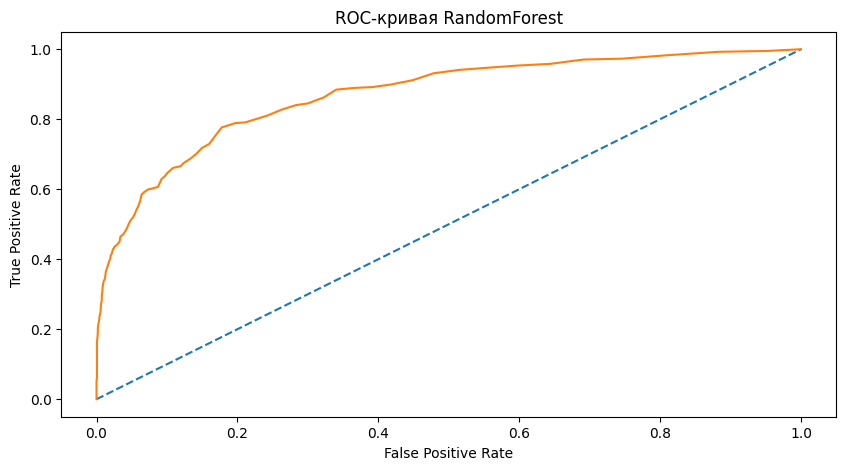

In [104]:
#Построим ROC кривую

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_RF) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot (fpr,tpr)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая RandomForest')
plt.show()

Значение AUC_ROC тут уже 0,87

**Рассмотрим модель LogisticRegression**

In [105]:
LR = LogisticRegression(random_state=MY_RANDOM_STATE, solver='liblinear')
LR.fit(features_train, target_train)
predict_LR = LR.predict(features_valid)
F1_LR = f1_score(target_valid, predict_LR)
print(f'F1: {F1_LR: .2f}')

F1:  0.29


In [106]:
#постоим матрицу ошибок

confusion_matrix(target_valid, predict_LR)

array([[1548,   45],
       [ 330,   77]], dtype=int64)

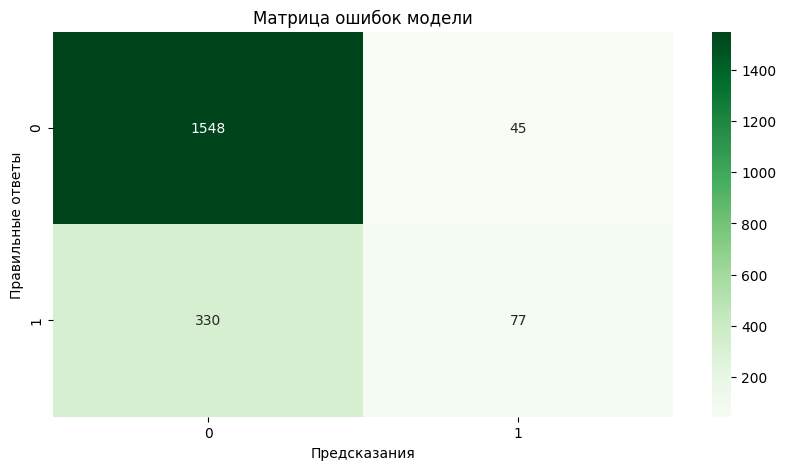

In [107]:
sns.heatmap(confusion_matrix(target_valid, predict_LR),
            annot=True, cmap='Greens', fmt='g')
plt.title(f'Матрица ошибок модели')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()


Хуже всех оказалась модель LogisticRegression, т.к. F1 тут всего 0,29. Значительно уменьшилось значение TP, увеличилось FN. Тут также происходит смещение в пользу Precision.

In [108]:
#найдем ROC_AUC

probabil_valid_LR = LR.predict_proba(features_valid)
probabil_one_valid_LR = probabil_valid_LR[:, 1]
AUC_ROC_LR = roc_auc_score(target_valid, probabil_one_valid_LR)
print(f'AUC_ROC модели LR: {AUC_ROC_LR: .2f}')

AUC_ROC модели LR:  0.77


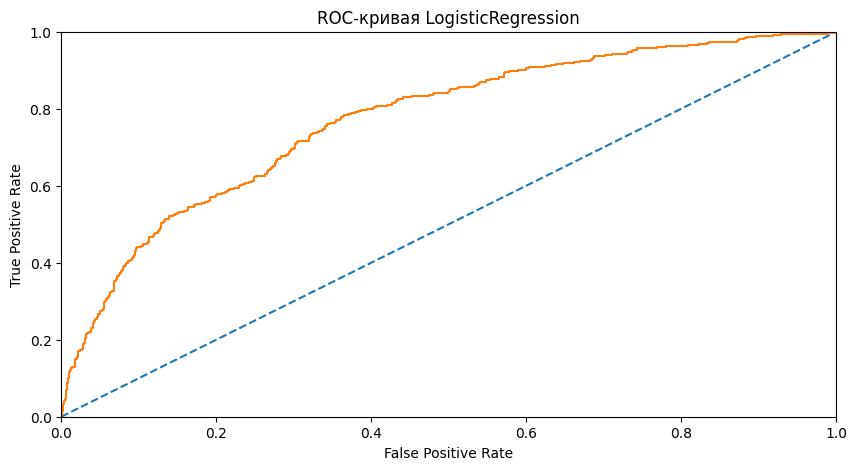

In [109]:
#Построим ROC кривую

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_LR) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot (fpr,tpr)
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая LogisticRegression')
plt.show()

AUC_ROC между деревом решений и случайным лесом.

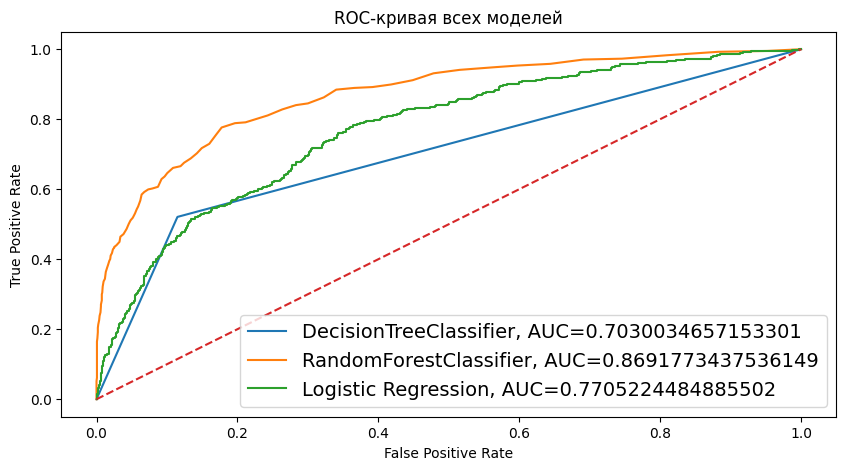

In [110]:
#Посмотрим ROC кривые на одном графике

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_DT) 
plt.plot (fpr,tpr,label="DecisionTreeClassifier, AUC="+str(AUC_ROC_DT))

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_RF) 
plt.plot (fpr,tpr,label="RandomForestClassifier, AUC="+str(AUC_ROC_RF))

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_LR) 
plt.plot (fpr,tpr,label="Logistic Regression, AUC="+str(AUC_ROC_LR))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая всех моделей')
plt.legend() 
plt.show()

In [111]:
#Сведем показатели в таблицу

Score_F1 = [F1_DT, F1_RF, F1_LR]
Score_ROC =  [AUC_ROC_DT, AUC_ROC_RF, AUC_ROC_LR]
Dictionary = {'F1':Score_F1, 'AUC_ROC':Score_ROC}
index = ['DecisionTree', 'RandomForest', 'LogisticRegression']
Score = pd.DataFrame(Dictionary, index)
display(Score)

,F1,AUC_ROC
DecisionTree,0.53,0.70
RandomForest,0.57,0.87
LogisticRegression,0.29,0.77


**Подведем промежуточные итоги**  
- Мы расмотрели три модели: DecisionTree, RandomForest и LogisticRegression  
- Все модели рассматривали без дополнительных параметров на несбалансированной выборке  
- Лучше всех в этих условиях себя показала моель RandomForest, значение F1 равно 0,57  
- Больше всех оказалась подвержена дисбалансу модель LogisticRegression

## Борьба с дисбалансом

**Увеличим выборку путем добавления положительного класса**

In [112]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=MY_RANDOM_STATE)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [113]:
#Посмотрим какой стала выборка

print(f"Количество строк в target_upsampled по классам: {np.bincount(target_upsampled)}")
print(target_upsampled.value_counts(normalize = 1))
print(target_upsampled.shape)   

Количество строк в target_upsampled по классам: [4778 4888]
1   0.51
0   0.49
Name: Exited, dtype: float64
(9666,)


**Также рассмотрим модели без дополнительных параметров**

In [114]:
#Модель DecisionTreeClassifier

DT_UP = DecisionTreeClassifier(random_state=MY_RANDOM_STATE)
DT_UP.fit(features_upsampled, target_upsampled)

predict_DT_UP = DT_UP.predict(features_valid)
F1_DT_UP = f1_score(target_valid, predict_DT_UP)
print(f'F1: {F1_DT_UP: .2f}')

F1:  0.48


In [115]:
confusion_matrix(target_valid, predict_DT_UP)

array([[1397,  196],
       [ 215,  192]], dtype=int64)

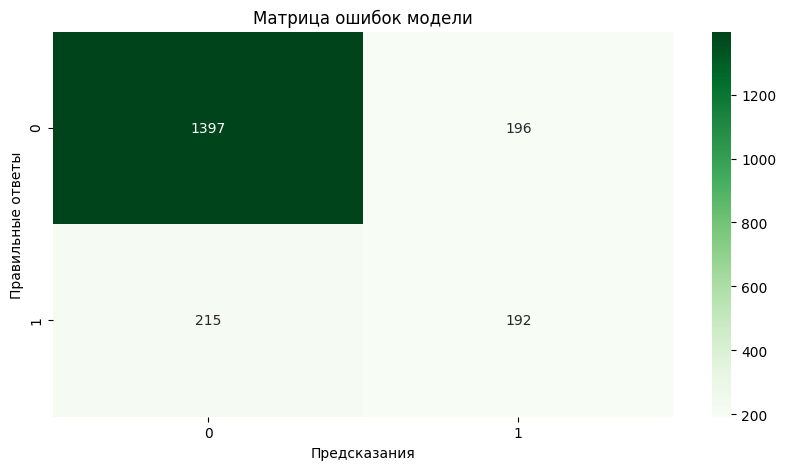

In [116]:
sns.heatmap(confusion_matrix(target_valid, predict_DT_UP),
            annot=True, cmap='Greens', fmt='g')
plt.title(f'Матрица ошибок модели')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()


Как видим показатель F1 даже сократился. Матрица практически не изменилась.

In [117]:
probabil_valid_DT_UP = DT_UP.predict_proba(features_valid)
probabil_one_valid_DT_UP = probabil_valid_DT_UP[:, 1]
AUC_ROC_DT_UP = roc_auc_score(target_valid, probabil_one_valid_DT_UP)
print(f'AUC_ROC модели DT_UP: {AUC_ROC_DT_UP: .2f}')

AUC_ROC модели DT_UP:  0.67


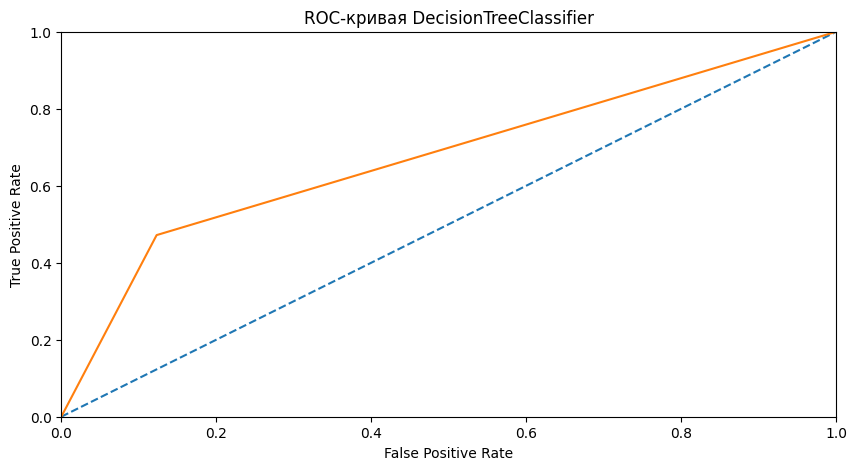

In [118]:
fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_DT_UP) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot (fpr,tpr)
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая DecisionTreeClassifier')
plt.show()

In [119]:
#Модель RandomForestClassifier

RF_UP = RandomForestClassifier(random_state=MY_RANDOM_STATE)
RF_UP.fit(features_upsampled, target_upsampled)

predict_RF_UP = RF_UP.predict(features_valid)
F1_RF_UP = f1_score(target_valid, predict_RF_UP)
print(f'F1: {F1_RF_UP: .2f}')

F1:  0.62


In [120]:
confusion_matrix(target_valid, predict_RF_UP)

array([[1487,  106],
       [ 176,  231]], dtype=int64)

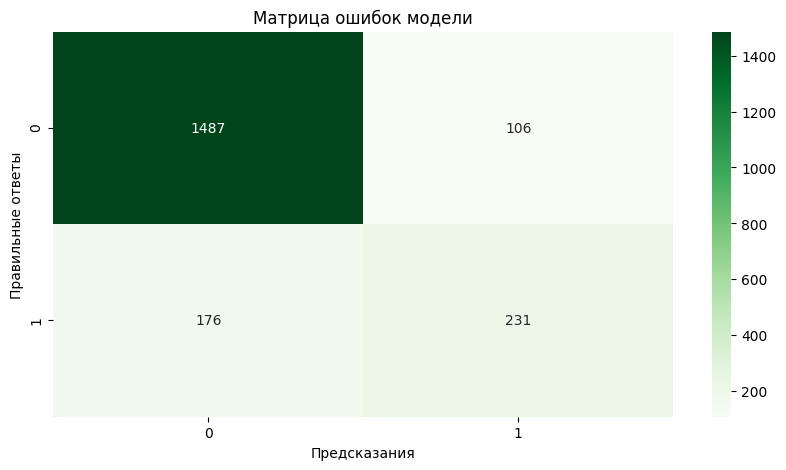

In [121]:
sns.heatmap(confusion_matrix(target_valid, predict_RF_UP),
            annot=True, cmap='Greens', fmt='g')
plt.title(f'Матрица ошибок модели')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()


У модели случайный лес, F1 вырос до 0,62 без учета дополнительных параметров.

In [122]:
probabil_valid_RF_UP = RF_UP.predict_proba(features_valid)
probabil_one_valid_RF_UP = probabil_valid_RF_UP[:, 1]
AUC_ROC_RF_UP = roc_auc_score(target_valid, probabil_one_valid_RF_UP)
print(f'AUC_ROC модели RF_UP: {AUC_ROC_RF_UP: .2f}')

AUC_ROC модели RF_UP:  0.86


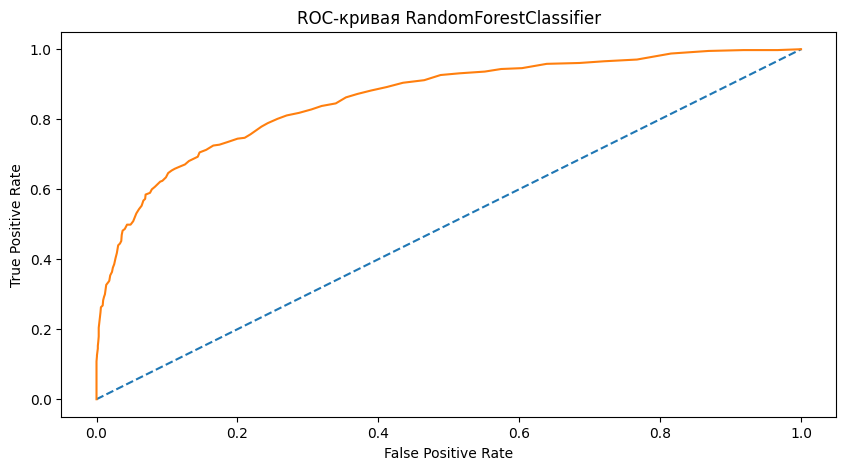

In [123]:
fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_RF_UP) 

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot (fpr,tpr)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая RandomForestClassifier')
plt.show()

In [124]:
#Модель LogisticRegression

LR_UP = LogisticRegression(random_state=MY_RANDOM_STATE, solver='liblinear')
LR_UP.fit(features_upsampled, target_upsampled)
predict_LR_UP = LR_UP.predict(features_valid)
F1_LR_UP = f1_score(target_valid, predict_LR_UP)
print(f'F1: {F1_LR_UP: .2f}')

F1:  0.50


In [125]:
confusion_matrix(target_valid, predict_LR_UP)

array([[1123,  470],
       [ 117,  290]], dtype=int64)

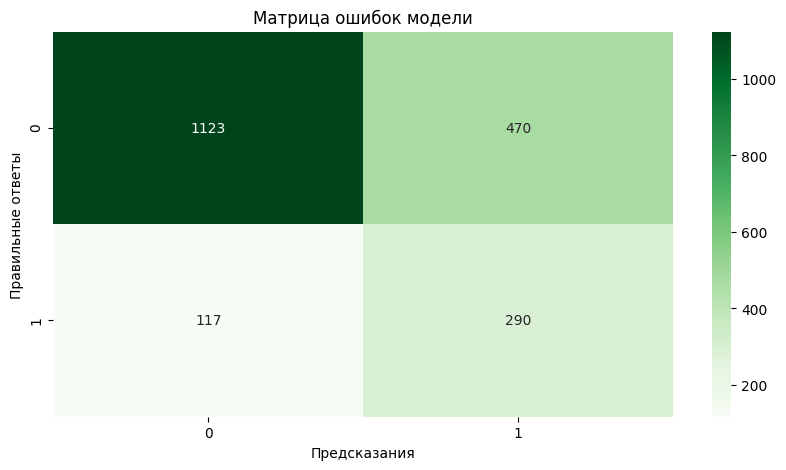

In [126]:
sns.heatmap(confusion_matrix(target_valid, predict_LR_UP),
            annot=True, cmap='Greens', fmt='g')
plt.title(f'Матрица ошибок модели')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()


У логистической регрессии F1 вырос значительно, как мы и предполагали в прошлом выводе на регрессию дисбаланс оказывает наибольшее влияние.

In [127]:
probabil_valid_LR_UP = LR_UP.predict_proba(features_valid)
probabil_one_valid_LR_UP = probabil_valid_LR_UP[:, 1]
AUC_ROC_LR_UP = roc_auc_score(target_valid, probabil_one_valid_LR_UP)
print(f'AUC_ROC модели LR_UP: {AUC_ROC_LR_UP: .2f}')

AUC_ROC модели LR_UP:  0.78


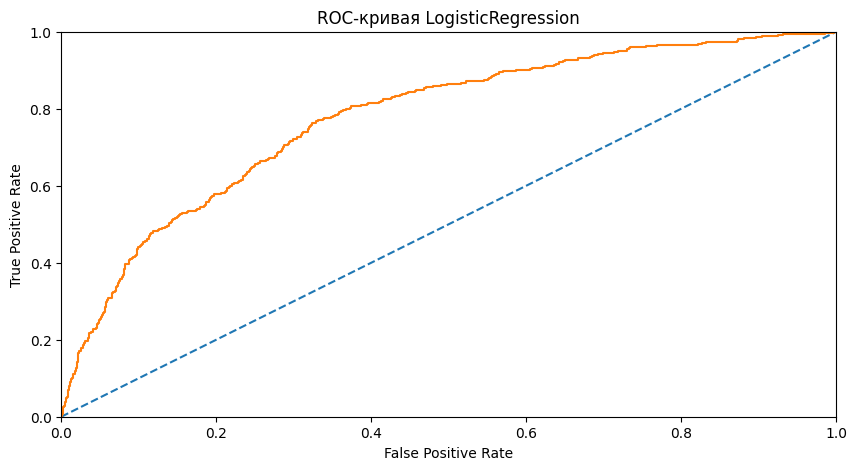

In [128]:
fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_LR_UP) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot (fpr,tpr)
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая LogisticRegression')
plt.show()

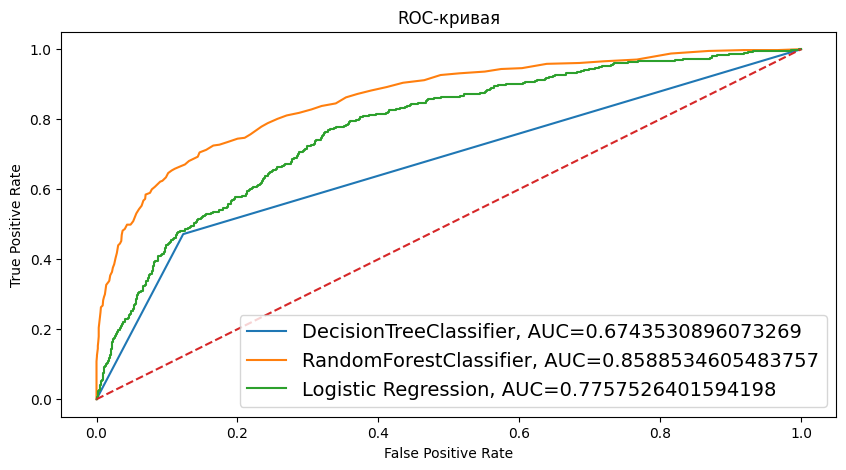

In [129]:
fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_DT_UP) 
plt.plot (fpr,tpr,label="DecisionTreeClassifier, AUC="+str(AUC_ROC_DT_UP))

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_RF_UP) 
plt.plot (fpr,tpr,label="RandomForestClassifier, AUC="+str(AUC_ROC_RF_UP))

fpr, tpr, thresholds = roc_curve(target_valid, probabil_one_valid_LR_UP) 
plt.plot (fpr,tpr,label="Logistic Regression, AUC="+str(AUC_ROC_LR_UP))

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC-кривая')
plt.legend() 
plt.show()

In [130]:
#Сведем показатели в таблицу

Score_F1_UP = [F1_DT_UP, F1_RF_UP, F1_LR_UP]
Score_ROC_UP =  [AUC_ROC_DT_UP, AUC_ROC_RF_UP, AUC_ROC_LR_UP]
Dictionary = {'F1_UP':Score_F1_UP, 'AUC_ROC_UP':Score_ROC_UP}
index = ['DecisionTree', 'RandomForest', 'LogisticRegression']
Score_UP = pd.DataFrame(Dictionary, index)
display(Score_UP)

,F1_UP,AUC_ROC_UP
DecisionTree,0.48,0.67
RandomForest,0.62,0.86
LogisticRegression,0.50,0.78


In [131]:
#Сведем данные в одну таблицу

Score_total = pd.concat([Score, Score_UP], axis=1)
Score_total

,F1,AUC_ROC,F1_UP,AUC_ROC_UP
DecisionTree,0.53,0.70,0.48,0.67
RandomForest,0.57,0.87,0.62,0.86
LogisticRegression,0.29,0.77,0.50,0.78


**После устранения дисбаланса методом Upsampling (в нашем случае увеличение объектов положительного класса) можно сделать следующие выводы:**  
- показатель метрики F1 на модели RandomForest увеличился до 0,62;  
- самый большой прирост метрики F1 составил у модели LogisticRegression с 0,29 до 0,5, можно сделать вывод, что дисбаланс больше всего влияет на модель LogisticRegression;  
- у модели DecisionTree показатель метрики даже снизился;  
- показатели AUC-ROC у всех моделей практически не изменились.

**Downsampling показывать в проекте не стал, т.к. проведя эксперемент этоn метод в нашем случае показал практически такие же результаты метрики F1**

## Подбор по параметрам

**Теперь посмотрим какие будут показатели, если использовать GridSearch**

In [132]:
#Для начала объеденим тренировочную и валидационную выборки

features_total = pd.concat([features_valid, features_train])
target_total = pd.concat([target_valid, target_train])

In [133]:
print(f"Количество строк в train по классам: {np.bincount(target_total)}")
print(target_total.value_counts(normalize = 1))
print(target_total.shape)

Количество строк в train по классам: [6371 1629]
0   0.80
1   0.20
Name: Exited, dtype: float64
(8000,)


Все прошло успешно

In [134]:
%%time
# Посмотрим на модель DecisionTree

parametrs = {'max_depth': range(1, 15),
             'criterion': ['gini', 'entropy'],
             'class_weight': ['balanced', None],
             }

grid_dt = GridSearchCV(DT, parametrs, scoring='f1')
grid_dt.fit(features_total, target_total)
print(f'Лучший estimator: {grid_dt.best_estimator_}')
print(f'F1 лучшей модели DecisionTree: {grid_dt.best_score_: .2f}')

DT_bestmodel = grid_dt.best_estimator_


Лучший estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, random_state=19221981)
F1 лучшей модели DecisionTree:  0.56
CPU times: total: 11 s
Wall time: 11.3 s


Как видим F1 равен 0,56

In [135]:
%%time
# Посмотрим на модель RandomForest

parametrs = {'max_depth': range(1, 16),
             'criterion': ['gini', 'entropy'],
             'class_weight': ['balanced', None],
             'n_estimators': range(1, 60, 10)
            }
grid_rf = GridSearchCV(RF, parametrs, scoring='f1', cv=5)
grid_rf.fit(features_total, target_total)
print(f'Лучший estimator: {grid_rf.best_estimator_}')
print(f'F1 лучшей модели RandomForest: {grid_rf.best_score_: .2f}')

RF_bestmodel = grid_rf.best_estimator_


Лучший estimator: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, n_estimators=41, random_state=19221981)
F1 лучшей модели RandomForest:  0.61
CPU times: total: 6min 43s
Wall time: 6min 48s


F1 равен 0,61

In [136]:
%%time
# Посмотрим на модель LogisticRegression

parameters = {'intercept_scaling': range(1, 6),
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', None]
              }
grid_lr = GridSearchCV(LR, parameters, scoring='f1', cv=5)
grid_lr.fit(features_total, target_total)
print(f'Лучший estimator: {grid_lr.best_estimator_}')
print(f'F1 лучшей модели LogisticRegression: {grid_lr.best_score_: .2f}')

LR_bestmodel = grid_lr.best_estimator_


Лучший estimator: LogisticRegression(class_weight='balanced', random_state=19221981,
                   solver='liblinear')
F1 лучшей модели LogisticRegression:  0.49
CPU times: total: 2.84 s
Wall time: 3.08 s


In [137]:
#Подведем итоги

print(f'F1 лучшей модели DecisionTree: {grid_dt.best_score_: .2f}')
print(f'F1 лучшей модели RandomForest: {grid_rf.best_score_: .2f}')
print(f'F1 лучшей модели LogisticRegression: {grid_lr.best_score_: .2f}')

F1 лучшей модели DecisionTree:  0.56
F1 лучшей модели RandomForest:  0.61
F1 лучшей модели LogisticRegression:  0.49


**При использовании GridSearch модели показали плюс минус такие же результаты как и при Upsampling лучшей оказалась модель RandomForest ее и будем проверять на тестовой выборке**

## Тестирование модели

In [138]:
#Проверим как поведет себя модель на тестовой выборке

predict_rf = RF_bestmodel.predict(features_test)
F1_RF_PAR = f1_score(target_test, predict_rf)
print(f'F1: {F1_RF_PAR : .2f}')
print(f'Accuracy: {accuracy_score(target_test, predict_rf): .2f}')

F1:  0.62
Accuracy:  0.82


**Мы добились нужного результата на тестовой выборке**

**Проверим модель на адекватность**

In [139]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=123456)
dummy_clf.fit(features_total, target_total)
dummy_clf.predict(features_test)
score_dummy = dummy_clf.score(features_test, target_test)
print('Качество модели Дамми:', score_dummy)

Качество модели Дамми: 0.6795


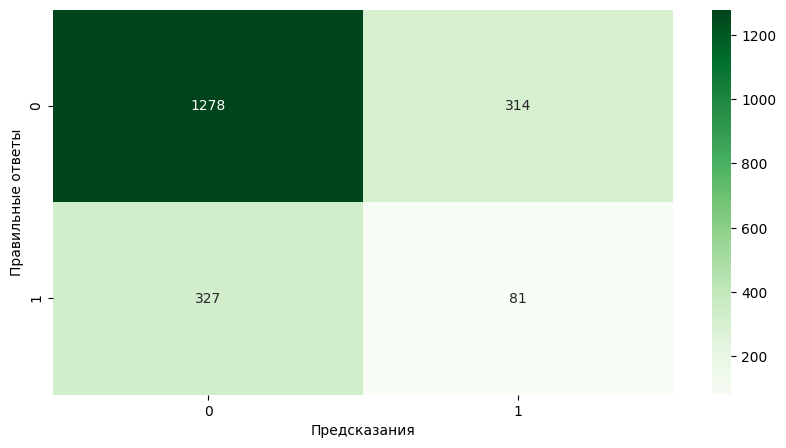

In [140]:
#plot_confusion_matrix(estimator=dummy_clf, X=features_test, y_true=target_test, cmap='Greens')
#plt.show()  
sns.heatmap(confusion_matrix(target_test, dummy_clf.predict(features_test)),
            annot=True, cmap='Greens', fmt='g')
#plt.title(f'Матрица ошибок модели')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()


**Качество модели Дамми 0,68, что меньше чем в нашей модели 0,82, можно сделать вывод, что наша модель адекватна**

In [141]:
#Проверим какие признаки оказалиcь главными для нашей модели.

Imp = pd.DataFrame({'Features': features_test.columns,
              'Importances': grid_rf.best_estimator_.feature_importances_
             })
display(Imp.sort_values(ascending=False, by='Importances'))

,Features,Importances
1,Age,0.33
4,NumOfProducts,0.20
3,Balance,0.12
0,CreditScore,0.08
7,EstimatedSalary,0.08
6,IsActiveMember,0.06
8,Geography_Germany,0.05
2,Tenure,0.04
10,Gender_Male,0.03
5,HasCrCard,0.01


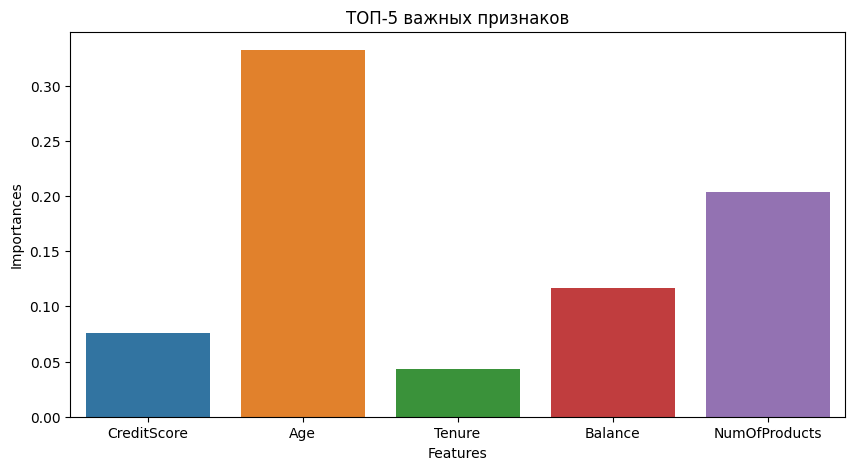

In [142]:
sns.barplot(x="Features", y="Importances", data=Imp[:5])
plt.title('ТОП-5 важных признаков')
plt.show()

**Самыми важными признаками оказались:**  
- возраст;  
- количество продуктов банка, используемых клиентом;  
- баланс на счете;  
- кредитный рейтинг;  
- сколько лет человек является клиентом банка.

## Заключение 

**Для выполнения поcтавленной задачи (доведение метрики F1-меры) до 0,59 было сделано следующее:**  
- были изучены данные;  
- проведена обработка данных;
- были проверены три модели DecisionTree, RandomForest, LogisticRegression;  
- при несбалансировнной выборке с соотношением целевого признака 80% к 20% все модели показали не очень высокие показатели, лучший результат у RandomForest  

| | F1| AUC-ROC|
| ----| -------| --- |
|DecisionTree      | 0,53  | 0,70   |
|RandomForest      | 0,57  | 0,87   |
|LogisticRegresion | 0,29  | 0,77   |


- после устранения дисбаланса методом Upsampling показатели улучшились у всех моделей кроме дерева решений, самый высокий результат у RandomForest, AUC практически не изменился  

| | F1| AUC-ROC|
| ----| -------| --- |
|DecisionTree      | 0,48  | 0,67   |
|RandomForest      | 0,62  | 0,86   |
|LogisticRegresion | 0,50  | 0,78   |  

- результаты Downsampling отражать не стал, т.к. мерика F1 практически не изменилась;
- как показали результаты больше всего дисбалансу подвержена модель LogisticRegresion;  
- далее объединил тренировочную выборку и валидационной и рассмотрел модели на несбалансировнной выборке с помощью GridSearch используя дополнительные параметры, включая class_weight, опять же самый лучший результат показала модель RandomForest  

| | F1| 
| ----| --- |
|DecisionTree      | 0,56  |
|RandomForest      | 0,61  | 
|LogisticRegresion | 0,49  |    

- так как лучшие результаты показала модель RandomForest, на ней было проведено тестирование. В резульате тестирования был достигнут результат `F1-меры равный 0,62`;
- также проверил модель на адекватность с помощью Dummy;  
- определили топ 5 признаков для модели.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*